In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np 
import math
import seaborn as sns
%matplotlib inline
def process_unis():
    unis = pd.read_csv('../../data/IPEDS/university_info/hd2021.csv', encoding='cp1252')
    ## Preprocessing meta-data files
    ### Updating names to match in rankings  
    unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
    unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
    unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
    unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
    unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
    unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"
        
    return unis

def process_completions(year):
    completions = pd.read_csv('../../data/IPEDS/completions/c%s_a.csv' % year)
    return completions
# hard coded it because of assignment errors

In [3]:
def startup():
    all_unis = {}
    all_completions = {}
    for year in range(2008, 2022):
        all_unis[year] = process_unis()
        all_completions[year] = process_completions(year)
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT']
    return all_unis, all_completions, cols

In [4]:
def region_processing(uni_data, completion_data, region):
    uni_boolmap = uni_data['OBEREG'] == region
    region_unis = uni_data[uni_boolmap]
    unitids = set(region_unis['UNITID'])
    completion_boolmap = completion_data['UNITID'].apply(lambda x: x in unitids)
    region_data = completion_data[completion_boolmap]
    return region_data, region_unis

In [5]:
reg_code_to_label = {0: 'US Service Schools', 1: 'New England', 2: 'Mid East', 3: 'Great Lakes', 4: 'Plains',\
     5: 'Southeast',6: 'Southwest', 7: 'Rocky Mountains',8: 'Far West', 9: 'Outlying Areas'}

In [6]:
def make_years(completions, unis, start, end):
    years = {}
    for year in range(start, end + 1):
        year_completions, year_unis = unis[year], completions[year]
        years[year] = [year_completions, year_unis]
    return years

In [7]:
# data is the dataframe already boolmapped with the proper data
def groupTotals(years):
    allStateCsData  = []
    allStateNonCsData = []
    for year in years:
        unis, data = years[year]
        csMerge, nonCsMerge = csVsNonCs(data, unis)
        csMerge['year'] = year
        nonCsMerge['year'] = year
        allStateCsData.append(csMerge)
        allStateNonCsData.append(nonCsMerge)
    allStateCsData = pd.concat(allStateCsData)
    allStateNonCsData = pd.concat(allStateNonCsData)
    return allStateCsData, allStateNonCsData
    
        
        
def csVsNonCs(data, unis):
    csBoolmap = data['CIPCODE'].apply(lambda x : x < 12 and x >= 11)
    cs = data[csBoolmap]
    csSum = cs.groupby('UNITID').sum()
    csSum = csSum.reset_index()
    uniqueIds = set(csSum['UNITID'].unique())
    nonCs = data[data.apply(lambda x: x['UNITID'] in uniqueIds, axis = 1)]
    nonCsSum = nonCs.groupby('UNITID').sum().reset_index()
    cols = ['UNITID', 'CTOTALW', 'CAIANT', 'CBKAAT', 'CHISPT', 'CTOTALT']
    csMerge = pd.merge(csSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    nonCsMerge = pd.merge(nonCsSum[cols], unis[['UNITID', 'LONGITUD', 'LATITUDE']], on = 'UNITID', how='left')
    return csMerge, nonCsMerge

In [8]:
def make_percents(cs, nonCs):
    cs = cs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    nonCs = nonCs.set_index(['UNITID', 'year', 'LONGITUD', 'LATITUDE'])
    cs = cs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    nonCs = nonCs.apply(lambda x: x / x['CTOTALT'], axis = 1)
    cs = cs.reset_index()
    nonCs = nonCs.reset_index()
    return cs, nonCs

In [9]:
def cs_nonCs_difference(cs, nonCs):
    cs = cs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    nonCs = nonCs.set_index(['LONGITUD', 'LATITUDE', 'UNITID', 'year'])
    difference = cs - nonCs
    difference.columns = ['d_%s' % col for col in difference.columns]
        
    difference = difference.reset_index()
    return difference

In [10]:
def get_avg(data):
    data = data.groupby('UNITID').mean()
    return data.reset_index()

In [11]:
def make_correlation_df(data, unis, demo):
    correlation_df_merge = pd.merge(data[['UNITID', 'd_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], unis, on='UNITID')
    non_differences = correlation_df_merge.drop(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT'], axis=1)
    correlations_df = non_differences.corrwith(correlation_df_merge[demo])
    #correlations_df = correlation_df_merge[['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']].corrwith(non_differences, axis=0)
    return correlations_df.dropna()
    


In [12]:
def average():
    all_unis, all_completions, cols = startup()
    years = make_years(all_completions, all_unis, 2008, 2021)
    cs_group, nonCs_group = groupTotals(years)
    cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
    difference = cs_nonCs_difference(cs_percent, nonCs_percent)
    average = get_avg(difference)
    maxes = {}
    demos = ['women', 'black', 'hispanic', 'natives']
    for i, demo in enumerate(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']):
        corr = make_correlation_df(average, all_unis[2021], demo)
        maxes[demos[i]]  = [corr.idxmin(), corr.idxmax()]
    return maxes

In [13]:
def by_year(year):
    all_unis, all_completions, cols = startup()
    years = make_years(all_completions, all_unis, year, year)
    cs_group, nonCs_group = groupTotals(years)
    cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
    difference = cs_nonCs_difference(cs_percent, nonCs_percent)
    maxes = {}
    demos = ['women', 'black', 'hispanic', 'natives']
    for i, demo in enumerate(['d_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']):
        corr = make_correlation_df(difference, all_unis[year], demo)
        maxes[demos[i]]  = [corr.idxmin(), corr.idxmax()]
    return maxes

In [15]:
all_unis, all_completions, cols = startup()
years = make_years(all_completions, all_unis, 2008, 2021)
cs_group, nonCs_group = groupTotals(years)
cs_percent, nonCs_percent = make_percents(cs_group, nonCs_group)
difference = cs_nonCs_difference(cs_percent, nonCs_percent)
average = get_avg(difference)


In [26]:
demo_stats = pd.merge(average[['UNITID', 'd_CTOTALW', 'd_CBKAAT', 'd_CHISPT', 'd_CAIANT']], all_unis[2021], on='UNITID')

In [56]:
corr_df = demo_stats.corr(method = 'spearman')

In [62]:
women_boolmap = abs(women_corr) >= 0.05

In [75]:
black_boolmap = abs(black_corr) >= 0.05

In [76]:
black = black_corr[black_boolmap]

In [63]:
women = women_corr[women_boolmap]

In [74]:
demo_stats.apply(lambda x: len(x.unique())).sort_values()[:50]

OPENPUBL      2
UGOFFER       2
GROFFER       2
LANDGRNT      2
DEGGRANT      2
POSTSEC       2
CYACTIVE      2
DEATHYR       2
HBCU          2
TRIBAL        2
ICLEVEL       3
CONTROL       3
PSEFLAG       3
CBSATYPE      3
F1SYSTYP      4
HOSPITAL      4
MEDICAL       4
DFRCUSCG      4
PSET4FLG      5
RPTMTH        5
OPEFLAG       6
NEWID         6
ACT           6
INSTCAT       7
INSTSIZE      7
HDEGOFR1      8
C21ENPRF      8
SECTOR        9
HLOFFER       9
OBEREG       10
LOCALE       13
C21UGPRF     17
CARNEGIE     18
C21SZSET     19
C21IPGRD     20
CLOSEDAT     20
C21IPUG      22
CCBASIC      32
C21BASIC     33
C15BASIC     33
C18BASIC     34
NECTA        37
FIPS         58
STABBR       58
CSA         171
DFRCGID     180
CHFTITLE    222
F1SYSCOD    237
F1SYSNAM    238
CNGDSTCD    441
dtype: int64

In [64]:
women

CCBASIC     -0.122361
C15BASIC    -0.104679
C18BASIC    -0.103199
HOSPITAL    -0.092324
C21IPUG     -0.091355
HLOFFER     -0.088465
LATITUDE    -0.088073
C21BASIC    -0.082851
F1SYSCOD    -0.079736
C21IPGRD    -0.075679
C21UGPRF    -0.073322
LANDGRNT    -0.073126
C21ENPRF    -0.068824
LOCALE      -0.068329
COUNTYCD    -0.066437
CNGDSTCD    -0.066198
FIPS        -0.062643
C21SZSET    -0.061248
TRIBAL      -0.060483
LONGITUD    -0.052960
RPTMTH       0.051977
UGOFFER      0.054077
F1SYSTYP     0.060301
d_CBKAAT     0.064893
DFRCUSCG     0.067337
DEGGRANT     0.071246
OBEREG       0.083195
d_CAIANT     0.084288
SECTOR       0.087301
ICLEVEL      0.094952
EIN          0.100568
INSTCAT      0.101621
GROFFER      0.111499
d_CTOTALW    1.000000
Name: d_CTOTALW, dtype: float64

In [53]:
for factor, score in women.iteritems():
    plt.scatter(demo_stats['d_CTOTALW'], demo_stats[factor])
    plt.title(score)
    plt.xlabel('Women')
    plt.ylabel(factor)
    plt.savefig('../../out/corr_scatter/women_%s_scatter' % factor)
    plt.close()

In [80]:
for factor, score in black_corr.iteritems():
    plt.scatter(demo_stats['d_CBKAAT'], demo_stats[factor])
    plt.title(score)
    plt.xlabel('Black')
    plt.ylabel(factor)
    plt.savefig('../../out/corr_scatter/black/black_%s_scatter' % factor)
    plt.close()

<AxesSubplot:>

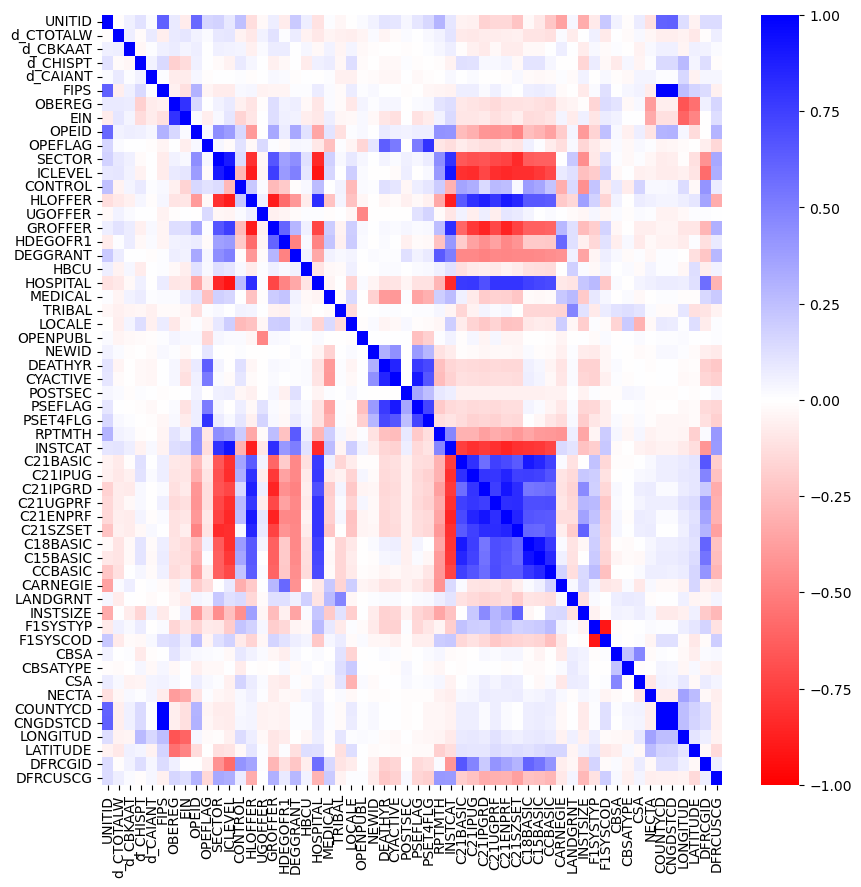

In [57]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, xticklabels=corr_df.columns, yticklabels=corr_df.index, vmin=-1, vmax=1, cmap='bwr_r')

In [58]:
women_corr = corr_df.loc['d_CTOTALW'].sort_values()

In [79]:
black_corr = corr_df.loc['d_CBKAAT'].sort_values()

In [60]:
hispanic_corr = corr_df.loc['d_CHISPT'].sort_values().head(30)

In [61]:
corr_df.loc['d_CAIANT'].sort_values().head()

OBEREG     -0.076846
EIN        -0.071617
LOCALE     -0.057831
TRIBAL     -0.057069
LATITUDE   -0.047440
Name: d_CAIANT, dtype: float64

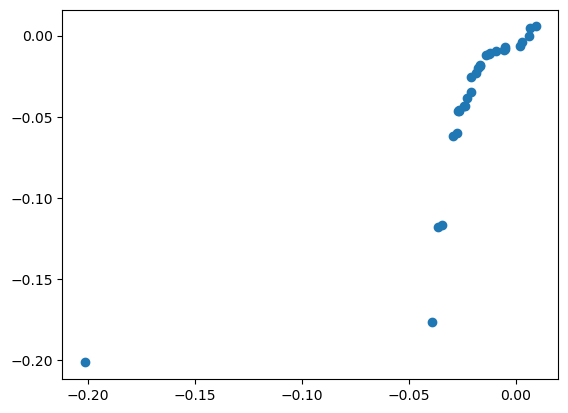

In [25]:
plt.scatter(black.index, hispanic.index)